<a href="https://colab.research.google.com/github/Navya-S/ERA/blob/main/ERA1S7F3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 306530941.91it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 108156869.49it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 120551018.78it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 23872843.07it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


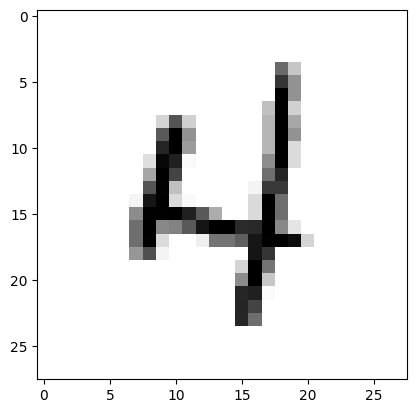

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

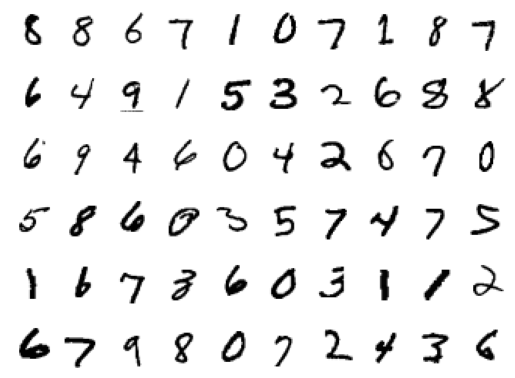

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [7]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# The model
Let's start with the model we first saw

In [27]:
class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), # 28>26 |1>3
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), # 26>24 |3>5
            nn.BatchNorm2d(8),
            nn.ReLU()
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), # 24>22 | 5>7
            nn.BatchNorm2d(8),
            nn.ReLU()
        )

        self.pool1 = nn.MaxPool2d(2, 2) #22>11 |7>8

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), #11>9 |8>12
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        # self.pool1 = nn.MaxPool2d(2, 2) # 8>4 | 14>16

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # 9>7 | 12>16
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1,1), padding=0, bias=False), # 7>7 | 16>16
            # nn.ReLU()
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7,7), padding=0, bias=False), # 7>1 | 16>28
            # nn.ReLU()
        )
        # self.conv1 = nn.Conv2d(1, 32, 3, padding=1) # 28>28 | 3
        # self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # 28 > 28 |  5
        # self.pool1 = nn.MaxPool2d(2, 2) # 28 > 14 | 6
        # self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # 14> 14 | 12
        # self.conv4 = nn.Conv2d(128, 256, 3, padding=1) #14 > 14 | 14
        # self.pool2 = nn.MaxPool2d(2, 2) # 14 > 7 | 28
        # self.conv5 = nn.Conv2d(256, 512, 3) # 7 > 5 | 30
        # self.conv6 = nn.Conv2d(512, 1024, 3) # 5 > 3 | 32 | 3*3*1024 | 3x3x1024x10 |
        # self.conv7 = nn.Conv2d(1024, 10, 3) # 3 > 1 | 34 | > 1x1x10

    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool1(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        # x = self.gap(x)
        # x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

        # x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        # x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        # x = F.relu(self.conv6(F.relu(self.conv5(x))))
        # # x = F.relu(self.conv7(x))
        # x = self.conv7(x)
        # x = x.view(-1, 10) #1x1x10> 10
        # return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [28]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model3().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             576
       BatchNorm2d-5            [-1, 8, 24, 24]              16
              ReLU-6            [-1, 8, 24, 24]               0
            Conv2d-7            [-1, 8, 22, 22]             576
       BatchNorm2d-8            [-1, 8, 22, 22]              16
              ReLU-9            [-1, 8, 22, 22]               0
        MaxPool2d-10            [-1, 8, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           1,152
      BatchNorm2d-12             [-1, 16, 9, 9]              32

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [29]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [31]:
model =  Model3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.15542829036712646 Batch_id=468 Accuracy=93.53: 100%|██████████| 469/469 [00:17<00:00, 26.78it/s]



Test set: Average loss: 0.0720, Accuracy: 9769/10000 (97.69%)

EPOCH: 1


Loss=0.0984661802649498 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:17<00:00, 27.48it/s]



Test set: Average loss: 0.0439, Accuracy: 9861/10000 (98.61%)

EPOCH: 2


Loss=0.03364809975028038 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:16<00:00, 27.86it/s]



Test set: Average loss: 0.0403, Accuracy: 9863/10000 (98.63%)

EPOCH: 3


Loss=0.05192313715815544 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:16<00:00, 28.48it/s]



Test set: Average loss: 0.0447, Accuracy: 9850/10000 (98.50%)

EPOCH: 4


Loss=0.012254394590854645 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s]



Test set: Average loss: 0.0354, Accuracy: 9884/10000 (98.84%)

EPOCH: 5


Loss=0.06931514292955399 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:16<00:00, 28.69it/s]



Test set: Average loss: 0.0350, Accuracy: 9895/10000 (98.95%)

EPOCH: 6


Loss=0.007820922881364822 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:16<00:00, 28.52it/s]



Test set: Average loss: 0.0314, Accuracy: 9891/10000 (98.91%)

EPOCH: 7


Loss=0.028372198343276978 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 27.82it/s]



Test set: Average loss: 0.0363, Accuracy: 9887/10000 (98.87%)

EPOCH: 8


Loss=0.012413573451340199 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:16<00:00, 28.52it/s]



Test set: Average loss: 0.0298, Accuracy: 9896/10000 (98.96%)

EPOCH: 9


Loss=0.016270313411951065 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:17<00:00, 27.02it/s]



Test set: Average loss: 0.0334, Accuracy: 9890/10000 (98.90%)

EPOCH: 10


Loss=0.007090192288160324 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:16<00:00, 28.33it/s]



Test set: Average loss: 0.0297, Accuracy: 9898/10000 (98.98%)

EPOCH: 11


Loss=0.012991326861083508 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:17<00:00, 27.45it/s]



Test set: Average loss: 0.0304, Accuracy: 9898/10000 (98.98%)

EPOCH: 12


Loss=0.0023458644282072783 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:16<00:00, 28.73it/s]



Test set: Average loss: 0.0305, Accuracy: 9898/10000 (98.98%)

EPOCH: 13


Loss=0.19451509416103363 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:17<00:00, 27.57it/s]



Test set: Average loss: 0.0335, Accuracy: 9888/10000 (98.88%)

EPOCH: 14


Loss=0.0012408446054905653 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:16<00:00, 28.88it/s]



Test set: Average loss: 0.0310, Accuracy: 9902/10000 (99.02%)



In [32]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

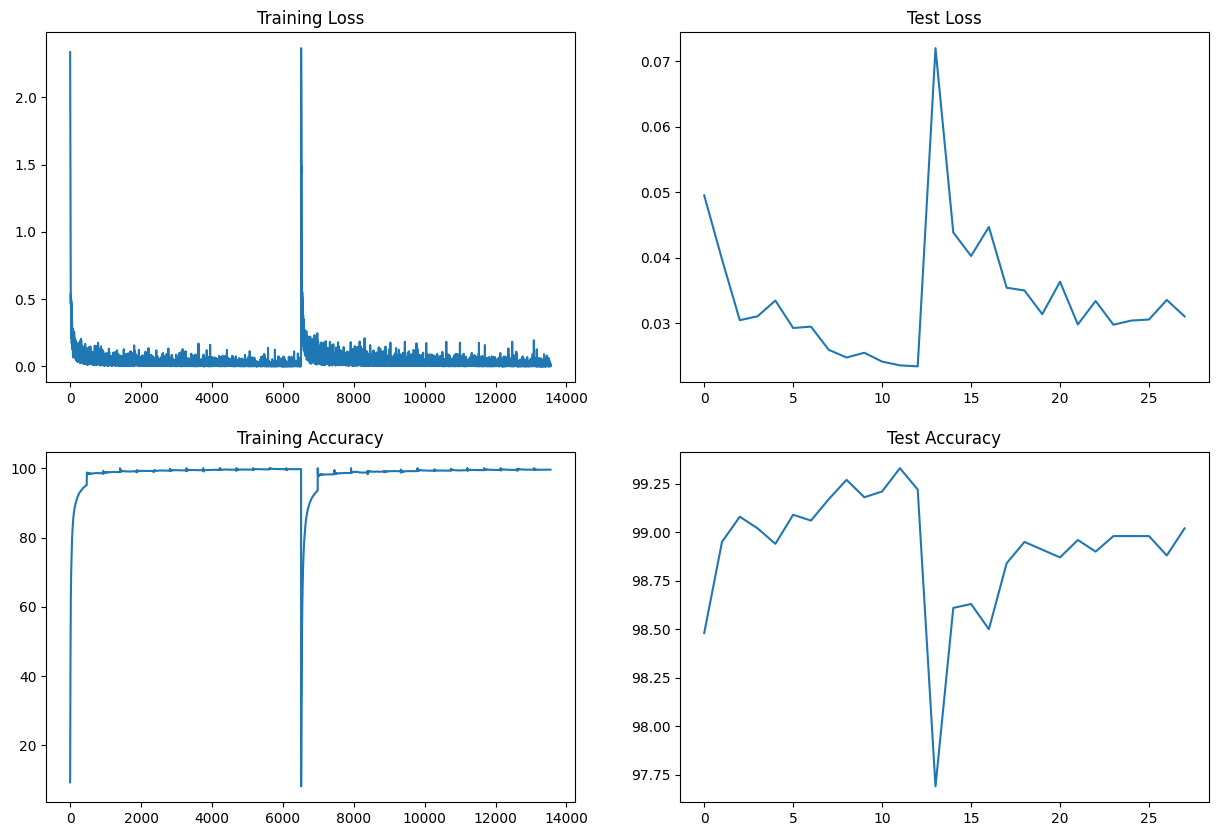

In [33]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")